# ns-nlive
Shows the simplest version of our method:
- Hare is taken directly from the grid
- No observational noise added to observed values (i.e. true = obs)
- The likelihood is defined solely by the expected observational uncertainties (assuming perfect emulation)

I want to test whether the issue of bitty posteriors is from the sampling method or the number of live points (or neither).

In [67]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_v2 import WMSE
from pitchfuncs_v2 import InversePCA
from pitchfuncs_v2 import emulator
from pitchfuncs_v2 import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time
from scipy import constants
import astropy.constants
import pickle


def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())


## 1) import hare and pitchfork

In [62]:
hare = pd.read_json("solar_hare.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i+1}' for i in range(5,40)]
hare_true = hare[outputs]

hare

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,star_feh,nu_0_4,...,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std,log_calc_effective_T_std
3806715,0.98,0.013508,0.24,2.1,4.384008,0.938134,0.796204,5633.170928,-0.046555,736.048182,...,0.891185,0.892424,0.893956,0.895084,0.895033,0.896013,0.896049,0.894976,0.892958,-0.378239


In [63]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


## 2) define priors
this uses the min and max trained ranges stored in the emulator pickle dict

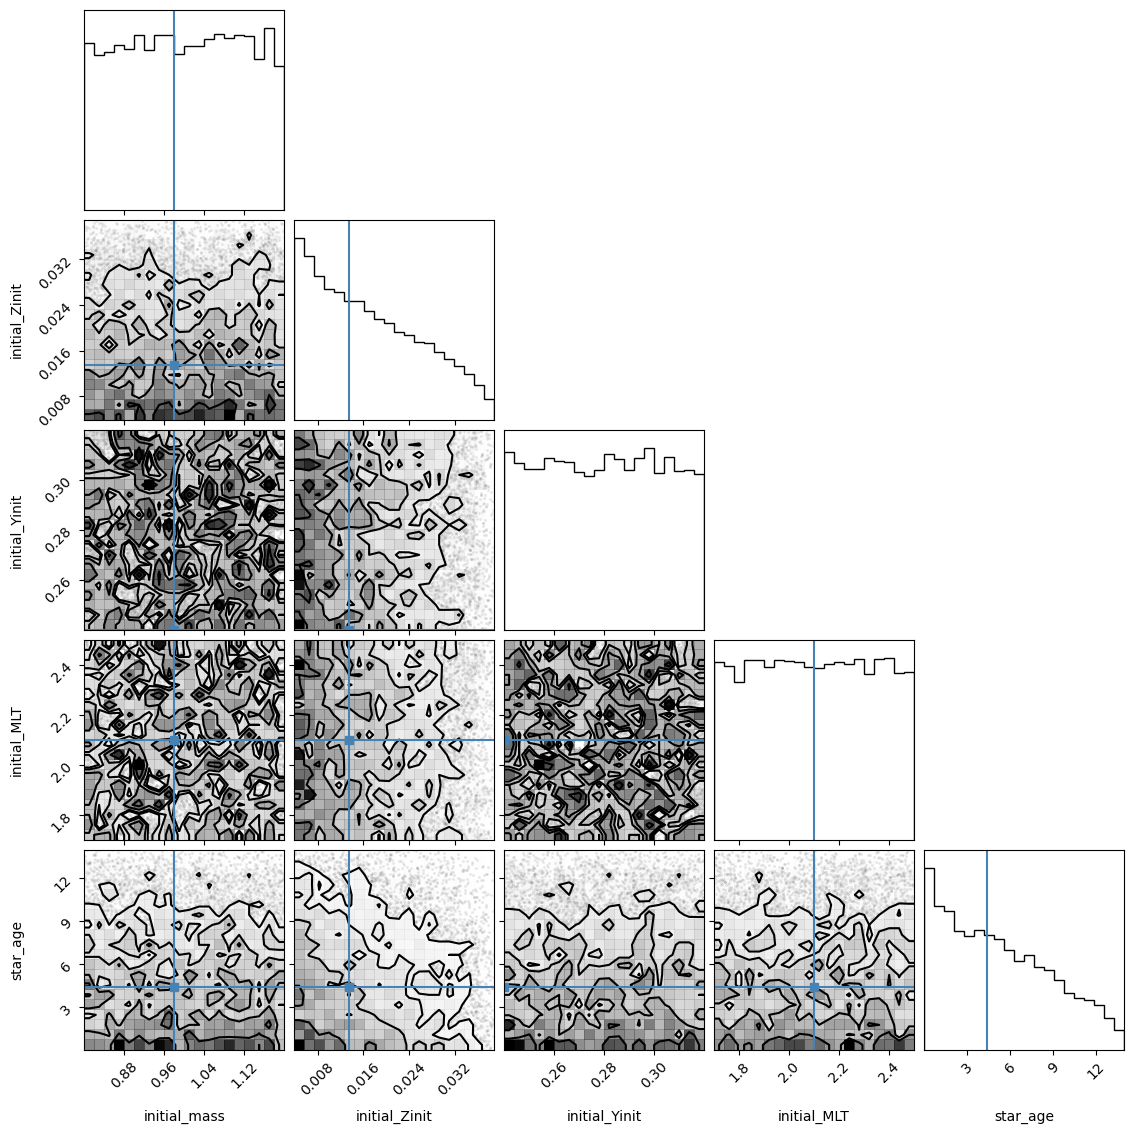

In [64]:
def grid_uniform_prior(pitchfork_ranges, header):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.uniform(loc=grid_min, scale=max(list(pitchfork_ranges["log_"+header].values()))-grid_min)

def grid_beta_prior(pitchfork_ranges, header,a=1,b=1):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.beta(loc=grid_min, scale=grid_max-grid_min, a=a, b=b)

mass_prior = grid_uniform_prior(pitchfork_ranges, "initial_mass")

Zinit_prior = grid_beta_prior(pitchfork_ranges,"initial_Zinit",a=0.9, b=1.5)

Yinit_prior = grid_uniform_prior(pitchfork_ranges, "initial_Yinit")

MLT_prior = grid_uniform_prior(pitchfork_ranges, "initial_MLT")

age_prior = grid_beta_prior(pitchfork_ranges, "star_age", a=0.9, b=1.5)

priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});

## 2) define uncertainties
in this notebook I'm assuming no emulation error, so this part is easy:

In [77]:
teff_unc = 70 #K
luminosity_unc = 0.02 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = .5 #\muHz

unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc for i in range(6,41)])
unc

array([7.e+01, 2.e-02, 1.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01])

## 3) define observed values
here's where we'd add simulated observational noise to the "true" values from the hare - in this notebook I assume we happen to observe exactly the truth values, so again this part is easy:

In [74]:
hare_obs = hare_true

## 4) show log-likelihood
now we've defined our "observed" values $\textbf{y}$ and their associated uncertainties $\sigma_{y}$, we have what we need to define our log-likelihood function that we'll use during nested sampling:
$$\mathcal{L}(\textbf{y}|\theta) = \sum_{i}\log\mathcal{N}(y_{i}, \sigma_{y_{i}}),$$
which is nice and simple when we aren't accounting for emulation error!

## 5) run dynesty

iter: 6020 | +250 | bound: 141 | nc: 1 | ncall: 137614 | eff(%):  4.565 | loglstar:   -inf < -41.006 <    inf | logz: -63.700 +/-  1.731 | dlogz:  0.001 >  0.259                                     

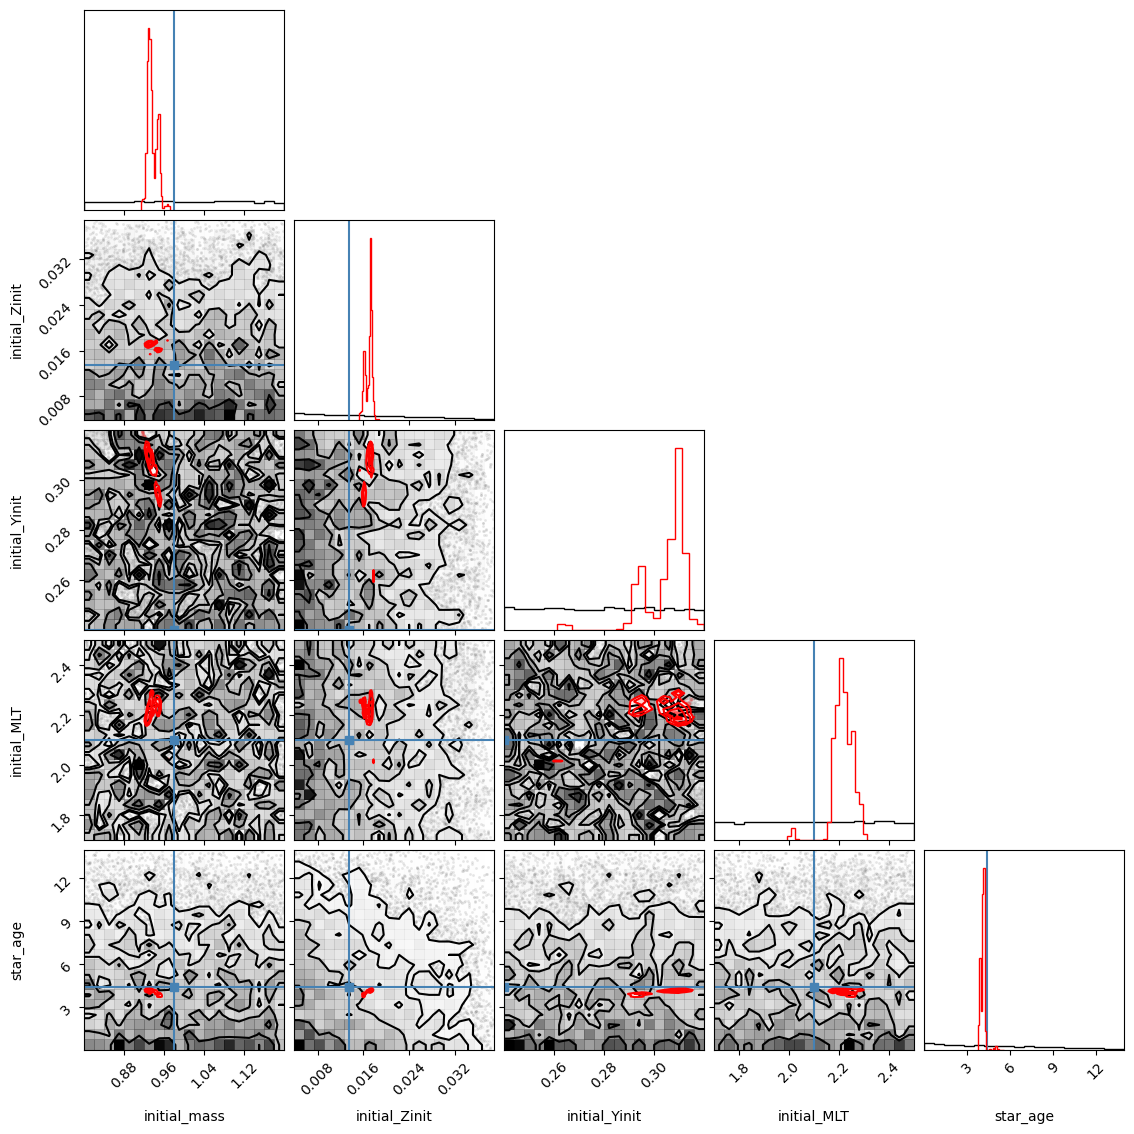

In [78]:
tic = time.time()
sampler = ns(priors=priors, observed_vals=hare_obs, observed_unc=unc, pitchfork=pitchfork, logl_scale=1)
posterior = sampler(nlive=250,sample='rwalk', bound='multi')
toc = time.time()

figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});
corner.corner(posterior, fig=figure, color='red',hist_kwargs={'density':True});

iter: 5367 | +250 | bound: 121 | nc: 1 | ncall: 121067 | eff(%):  4.649 | loglstar:   -inf < -38.442 <    inf | logz: -58.520 +/-    nan | dlogz:  0.001 >  0.259                                     

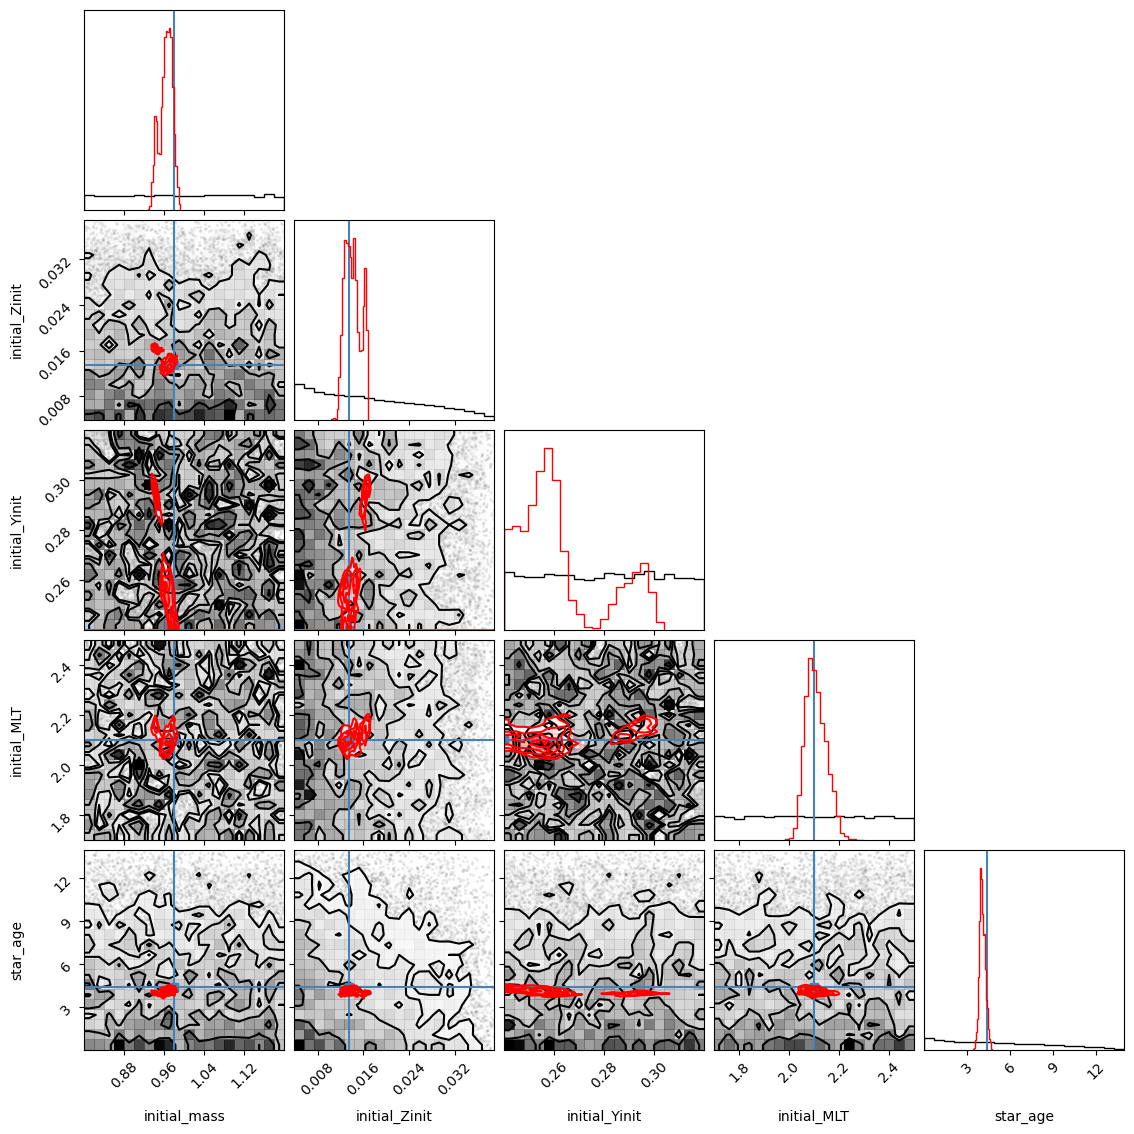

In [75]:
tic = time.time()
sampler = ns(priors=priors, observed_vals=hare_obs, observed_unc=unc, pitchfork=pitchfork, logl_scale=1)
posterior = sampler(nlive=250,sample='rwalk', bound='multi')
toc = time.time()

figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});
corner.corner(posterior, fig=figure, color='red',hist_kwargs={'density':True});

# 6) nlive test
try sampling for the same Hare at different nlive values to see what we end up with

In [ ]:
nlives = [250, 500, 1000, 2000, 4000]


for nlive in nlives:
    sampler = ns(priors=priors, observed_vals=hare_obs, observed_unc=unc, pitchfork=pitchfork, logl_scale=1)
    posterior = sampler(nlive=nlive,sample='rwalk', bound='multi')

In [ ]:
posteriors_dict = {}
for nlive in n_lives:
    print(f'current iteration: {i}', end='\r')
    sampler = ns(priors=priors, observed_vals=hare_obs, observed_unc=unc, pitchfork=pitchfork, logl_scale=1)
    posterior_i = sampler(nlive=nlive,sample='rwalk', bound='multi')
    posteriors_dict[f'posterior_{i}'] = posterior_i